https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

In [1]:
model_name = "resnet18"

# Train

## Import the modules

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import time

## Moving Your Custom Datasets Into Your Cloud VM

In [3]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/MyDrive/Classification/City/v5

data	  resnet18.ipynb  squeezenet1_1
resnet18  resnet50.ipynb  squeezenet1_1.ipynb


In [5]:
%cd content

/content


In [6]:
!pwd

/content


In [7]:
!mkdir data

In [8]:
!cp /content/gdrive/MyDrive/Classification/City/v5/data/train.zip ./
!cp /content/gdrive/MyDrive/Classification/City/v5/data/valid.zip ./

In [9]:
!unzip ./train.zip -d data/
!unzip ./valid.zip -d data/

Archive:  ./train.zip
   creating: data/train/
   creating: data/train/Birmingham/
  inflating: data/train/Birmingham/00076.jpg  
  inflating: data/train/Birmingham/00077.jpg  
  inflating: data/train/Birmingham/00078.jpg  
  inflating: data/train/Birmingham/00079.jpg  
  inflating: data/train/Birmingham/00080.jpg  
  inflating: data/train/Birmingham/00081.jpg  
  inflating: data/train/Birmingham/00082.jpg  
  inflating: data/train/Birmingham/00083.jpg  
  inflating: data/train/Birmingham/00084.jpg  
  inflating: data/train/Birmingham/00085.jpg  
  inflating: data/train/Birmingham/00086.jpg  
  inflating: data/train/Birmingham/00087.jpg  
  inflating: data/train/Birmingham/00088.jpg  
  inflating: data/train/Birmingham/00089.jpg  
  inflating: data/train/Birmingham/00090.jpg  
  inflating: data/train/Birmingham/00091.jpg  
  inflating: data/train/Birmingham/00092.jpg  
  inflating: data/train/Birmingham/00093.jpg  
  inflating: data/train/Birmingham/00094.jpg  
  inflating: data/train/

## Define the train / validation dataset loader

In [10]:
data_dir_train = 'data/train'
data_dir_valid = 'data/valid'

def load_split_train_test(datadirtrain, datadirtest):
    
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    train_data = datasets.ImageFolder(datadirtrain,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadirtest,
                    transform=test_transforms)    
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir_train, data_dir_valid)
print(trainloader.dataset.classes)

['Birmingham', 'Chester', 'Dublin', 'Edinburgh', 'Exeter', 'Glasgow', 'London', 'Newcastle', 'Sheffield']


## Determine whether we have GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
torch.cuda.is_available()

True

## Load a pretrained model

In [13]:
model = models.resnet18(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


- Freeze the pre-trained layers, so we don't backprop through them during training
- Re-define the final fully-connected layer that we'll train with our images
- Create the loss function https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
- Pick an optimizer
- Pick the learning rate


In [14]:
for param in model.parameters():
    param.requires_grad = False

num_classes = len(trainloader.dataset.classes)
print(num_classes)

model.fc = nn.Linear(512, num_classes)

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.to(device)

9


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

Epoch 1/200.. Train loss: 3.347.. Test loss: 3.268.. Test accuracy: 0.089
Epoch 1/200.. Time: 8.512
Epoch 2/200.. Train loss: 4.218.. Test loss: 2.482.. Test accuracy: 0.125
Epoch 2/200.. Train loss: 2.199.. Test loss: 2.334.. Test accuracy: 0.122
Epoch 2/200.. Time: 10.147
Epoch 3/200.. Train loss: 2.923.. Test loss: 2.327.. Test accuracy: 0.120
Epoch 3/200.. Train loss: 2.548.. Test loss: 2.241.. Test accuracy: 0.123
Epoch 3/200.. Time: 10.077
Epoch 4/200.. Train loss: 2.601.. Test loss: 2.257.. Test accuracy: 0.114
Epoch 4/200.. Time: 7.977
Epoch 5/200.. Train loss: 2.617.. Test loss: 2.203.. Test accuracy: 0.179
Epoch 5/200.. Train loss: 2.592.. Test loss: 2.227.. Test accuracy: 0.142
Epoch 5/200.. Time: 10.142
Epoch 6/200.. Train loss: 2.582.. Test loss: 2.214.. Test accuracy: 0.143
Epoch 6/200.. Train loss: 2.584.. Test loss: 2.201.. Test accuracy: 0.160
Epoch 6/200.. Time: 9.987
Epoch 7/200.. Train loss: 2.606.. Test loss: 2.211.. Test accuracy: 0.144
Epoch 7/200.. Time: 8.010
E

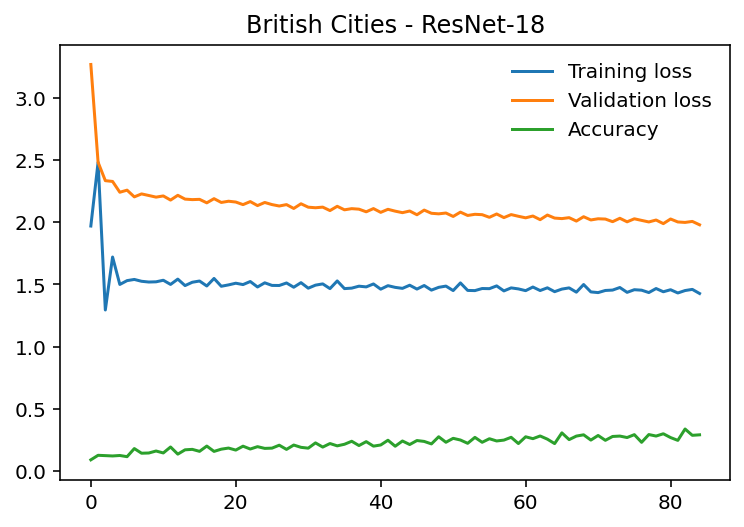

Epoch 51/200.. Train loss: 2.529.. Test loss: 2.014.. Test accuracy: 0.292
Epoch 51/200.. Time: 8.011
Epoch 52/200.. Train loss: 2.429.. Test loss: 1.989.. Test accuracy: 0.258
Epoch 52/200.. Train loss: 2.414.. Test loss: 1.998.. Test accuracy: 0.313
Epoch 52/200.. Time: 10.074
Epoch 53/200.. Train loss: 2.443.. Test loss: 1.996.. Test accuracy: 0.250
Epoch 53/200.. Train loss: 2.455.. Test loss: 1.975.. Test accuracy: 0.287
Epoch 53/200.. Time: 9.951
Epoch 54/200.. Train loss: 2.488.. Test loss: 2.003.. Test accuracy: 0.319
Epoch 54/200.. Time: 7.860
Epoch 55/200.. Train loss: 2.423.. Test loss: 1.975.. Test accuracy: 0.289
Epoch 55/200.. Train loss: 2.456.. Test loss: 2.000.. Test accuracy: 0.299
Epoch 55/200.. Time: 9.982
Epoch 56/200.. Train loss: 2.455.. Test loss: 1.987.. Test accuracy: 0.250
Epoch 56/200.. Train loss: 2.415.. Test loss: 1.975.. Test accuracy: 0.315
Epoch 56/200.. Time: 9.992
Epoch 57/200.. Train loss: 2.475.. Test loss: 1.991.. Test accuracy: 0.308
Epoch 57/200

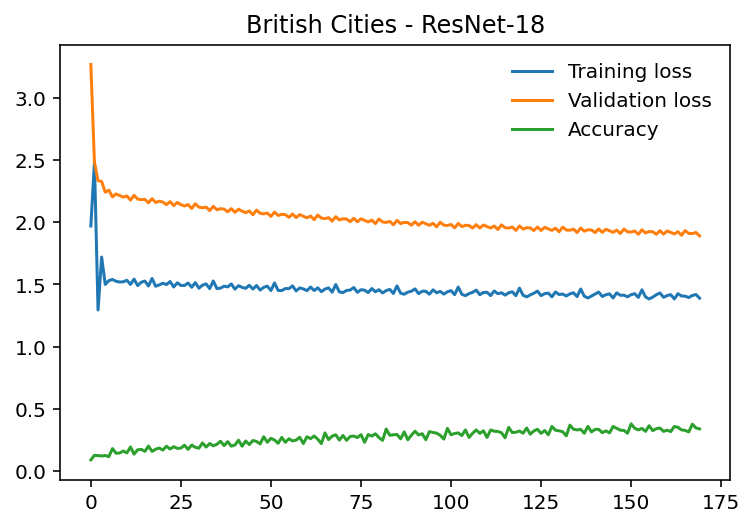

Epoch 101/200.. Train loss: 2.465.. Test loss: 1.926.. Test accuracy: 0.344
Epoch 101/200.. Time: 7.917
Epoch 102/200.. Train loss: 2.367.. Test loss: 1.901.. Test accuracy: 0.318
Epoch 102/200.. Train loss: 2.338.. Test loss: 1.913.. Test accuracy: 0.371
Epoch 102/200.. Time: 10.189
Epoch 103/200.. Train loss: 2.362.. Test loss: 1.911.. Test accuracy: 0.331
Epoch 103/200.. Train loss: 2.398.. Test loss: 1.891.. Test accuracy: 0.350
Epoch 103/200.. Time: 9.967
Epoch 104/200.. Train loss: 2.422.. Test loss: 1.920.. Test accuracy: 0.349
Epoch 104/200.. Time: 7.994
Epoch 105/200.. Train loss: 2.362.. Test loss: 1.892.. Test accuracy: 0.328
Epoch 105/200.. Train loss: 2.385.. Test loss: 1.918.. Test accuracy: 0.345
Epoch 105/200.. Time: 10.048
Epoch 106/200.. Train loss: 2.400.. Test loss: 1.906.. Test accuracy: 0.326
Epoch 106/200.. Train loss: 2.337.. Test loss: 1.894.. Test accuracy: 0.354
Epoch 106/200.. Time: 10.056
Epoch 107/200.. Train loss: 2.413.. Test loss: 1.912.. Test accuracy:

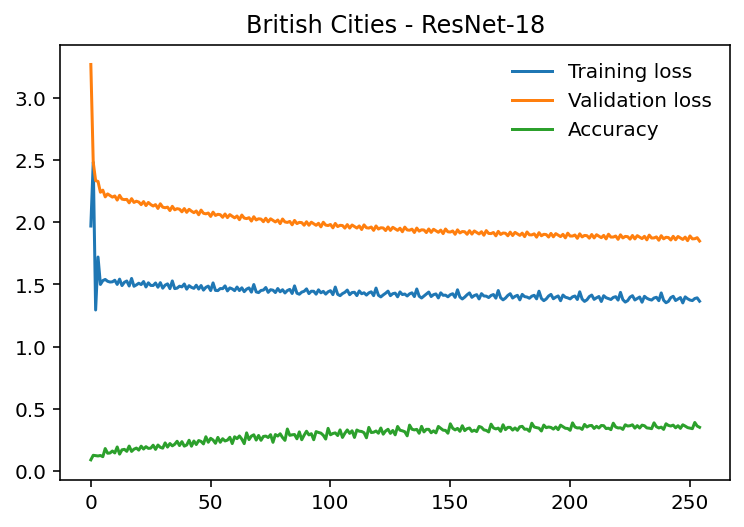

Epoch 151/200.. Train loss: 2.426.. Test loss: 1.885.. Test accuracy: 0.362
Epoch 151/200.. Time: 8.029
Epoch 152/200.. Train loss: 2.326.. Test loss: 1.859.. Test accuracy: 0.336
Epoch 152/200.. Train loss: 2.290.. Test loss: 1.872.. Test accuracy: 0.378
Epoch 152/200.. Time: 10.260
Epoch 153/200.. Train loss: 2.308.. Test loss: 1.870.. Test accuracy: 0.365
Epoch 153/200.. Train loss: 2.362.. Test loss: 1.850.. Test accuracy: 0.360
Epoch 153/200.. Time: 10.191
Epoch 154/200.. Train loss: 2.379.. Test loss: 1.880.. Test accuracy: 0.362
Epoch 154/200.. Time: 8.021
Epoch 155/200.. Train loss: 2.321.. Test loss: 1.852.. Test accuracy: 0.349
Epoch 155/200.. Train loss: 2.341.. Test loss: 1.879.. Test accuracy: 0.363
Epoch 155/200.. Time: 10.192
Epoch 156/200.. Train loss: 2.363.. Test loss: 1.866.. Test accuracy: 0.347
Epoch 156/200.. Train loss: 2.287.. Test loss: 1.855.. Test accuracy: 0.370
Epoch 156/200.. Time: 10.042
Epoch 157/200.. Train loss: 2.371.. Test loss: 1.874.. Test accuracy

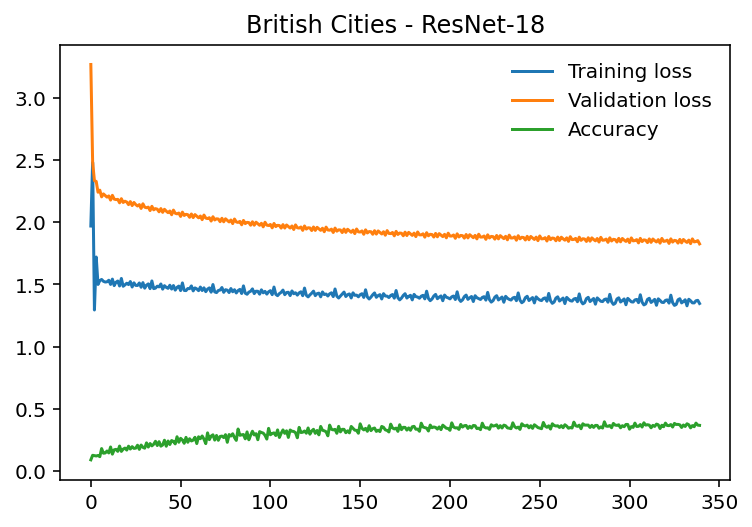

In [15]:
epochs = 200
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_lst = [], [], []

for epoch in range(epochs):
    start = time.time()
    
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_lst.append(accuracy/len(testloader))                   
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
    end = time.time()
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time: {end-start:.3f}")
    
    if (epoch+1) % 50 == 0:
      torch.save(model, f'city_{model_name}_{epoch+1}.pth')
      !cp 'city_{model_name}_{epoch+1}.pth' /content/gdrive/MyDrive/Classification/City/v5/resnet18/

      plt.plot(train_losses, label='Training loss')
      plt.plot(test_losses, label='Validation loss')
      plt.plot(accuracy_lst, label='Accuracy')
      plt.title('British Cities - ResNet-18')
      plt.legend(frameon=False)
      plt.show()



## Plot loss

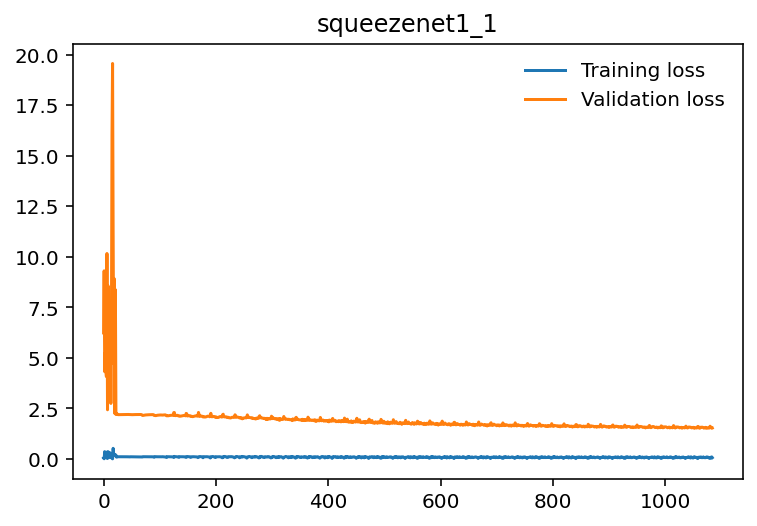

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

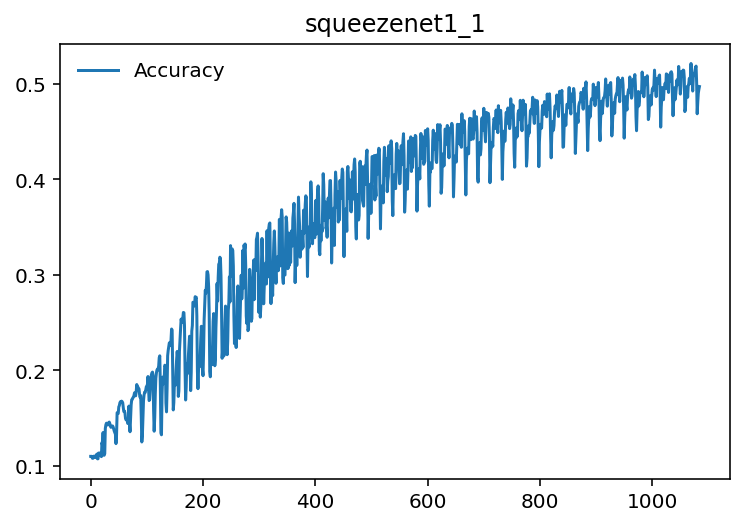

In [ ]:
plt.plot(accuracy_lst, label='Accuracy')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

# Train from last stop

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

%cd content

!mkdir data
!cp /content/gdrive/MyDrive/Classification/City/v4/data/train.zip ./
!cp /content/gdrive/MyDrive/Classification/City/v4/data/valid.zip ./
!unzip ./train.zip -d data/
!unzip ./valid.zip -d data/

data_dir_train = 'data/train'
data_dir_valid = 'data/valid'

def load_split_train_test(datadirtrain, datadirtest):
    
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],)
                                       ])    
    
    train_data = datasets.ImageFolder(datadirtrain,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadirtest,
                    transform=test_transforms)    
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir_train, data_dir_valid)
print(trainloader.dataset.classes)

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/Newcastle/SafeRotate_015_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_016_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_017_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_018_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_020_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_023_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_026_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_027_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_028_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_029_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_030_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_033_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_034_Newcastle.jpg  
  inflating: data/train/Newcastle/SafeRotate_035_Newcastle.jpg  
  inflating: data/trai

In [ ]:
!cp /content/gdrive/MyDrive/Classification/City/v4/squeezenet1_1/city_squeezenet1_1_100.pth ./
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load(f'city_{model_name}_100.pth')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [ ]:
import time
# from torchvision.models.squeezenet import squeezenet1_1
epochs = 50
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_lst = [], [], []

for epoch in range(epochs):
    start = time.time()
    
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_lst.append(accuracy/len(testloader))                   
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
    end = time.time()
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time: {end-start:.3f}")
    
    if (epoch+1) % 50 == 0:
      torch.save(model, f'city_{model_name}_{epoch+101}.pth')
      !cp 'city_{model_name}_{epoch+101}.pth' /content/gdrive/MyDrive/Classification/City/v4/squeezenet1_1/

Epoch 1/50.. Train loss: 1.708.. Test loss: 1.431.. Test accuracy: 0.555
Epoch 1/50.. Train loss: 1.134.. Test loss: 1.475.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.155.. Test loss: 1.505.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.202.. Test loss: 1.531.. Test accuracy: 0.550
Epoch 1/50.. Train loss: 1.542.. Test loss: 1.561.. Test accuracy: 0.548
Epoch 1/50.. Train loss: 1.875.. Test loss: 1.602.. Test accuracy: 0.534
Epoch 1/50.. Train loss: 1.315.. Test loss: 1.635.. Test accuracy: 0.524
Epoch 1/50.. Train loss: 1.501.. Test loss: 1.640.. Test accuracy: 0.518
Epoch 1/50.. Train loss: 1.296.. Test loss: 1.642.. Test accuracy: 0.512
Epoch 1/50.. Train loss: 1.595.. Test loss: 1.643.. Test accuracy: 0.505
Epoch 1/50.. Train loss: 1.783.. Test loss: 1.638.. Test accuracy: 0.515
Epoch 1/50.. Train loss: 1.776.. Test loss: 1.631.. Test accuracy: 0.517
Epoch 1/50.. Train loss: 1.844.. Test loss: 1.629.. Test accuracy: 0.523
Epoch 1/50.. Train loss: 1.687.. Test loss: 1.623..

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

In [ ]:
plt.plot(accuracy_lst, label='Accuracy')
plt.title(model_name)
plt.legend(frameon=False)
plt.show()

# Test

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

In [ ]:
data_dir = '/content/gdrive/MyDrive/Classification/Letter/v2/data/test'

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load(f'letters_{model_name}.pth')
model.eval()
model

In [ ]:


def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels



In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()